In [1]:
import sqlite3
from pathlib import Path

__file__ = %pwd
DATA = Path(__file__).parent.parent / "data"
PRIORITIES = DATA / "Priorities"
DATABASE = DATA / "databases" / "exploration.db"

import sys
sys.path.append(str(DATA.parent))  # Add the parent directory of 'modeling' to the Python path

con = sqlite3.connect(DATABASE)
cur = con.cursor()

In [2]:
import pandas as pd
import numpy as np

# Use 2020-21 data
df_2020_21 = pd.read_sql_query("SELECT * FROM ACGRWide WHERE Year = '2020-21'", con)
columns_to_drop = [col for col in df_2020_21.columns if col.startswith("UniReqs") or col.startswith("RegHSDiploma") or col.startswith("Dropout")]

# Lasso

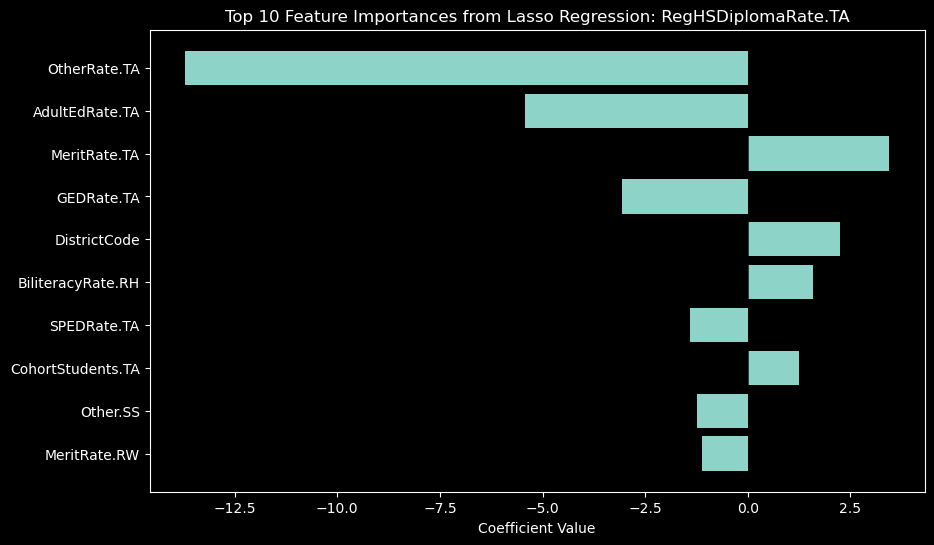

R^2 Score: -0.0013043990352201718
Mean Squared Error: 574.08459608985
Root Mean Squared Error: 23.960062522661538


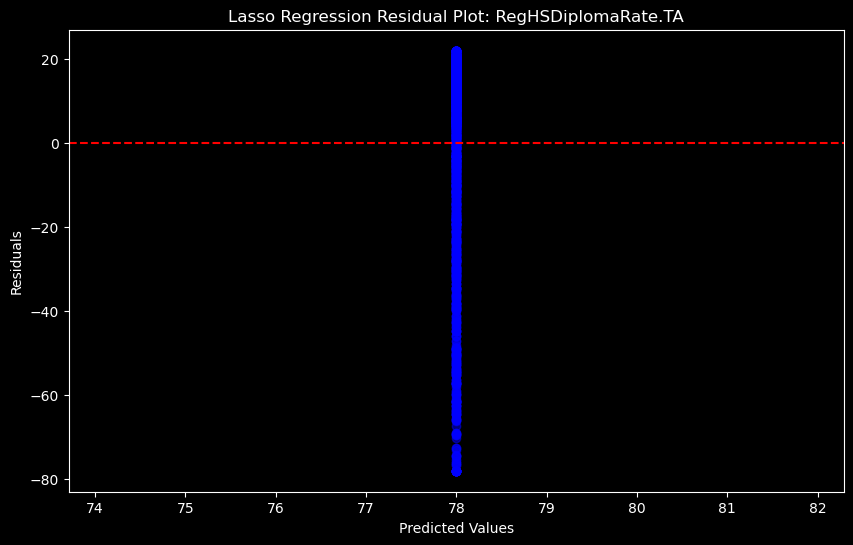

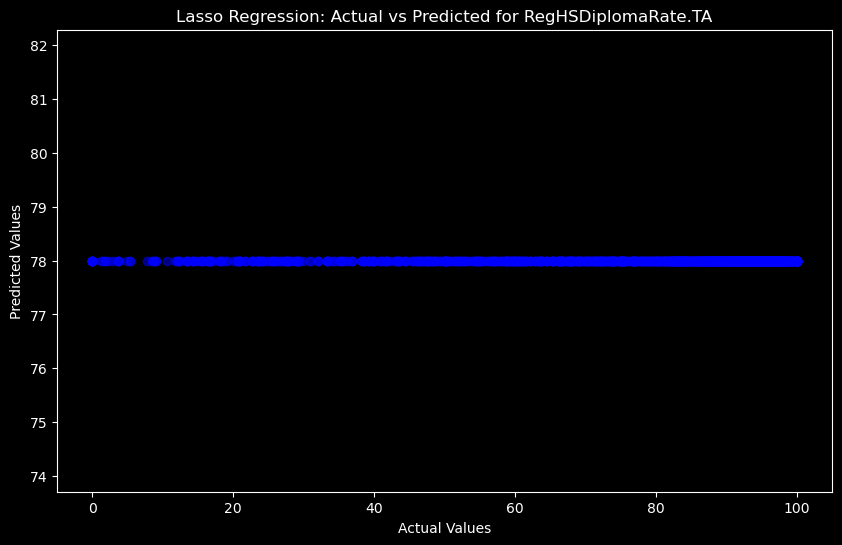

In [3]:
import modeling.utils.lasso as lasso_utils

target_column = "RegHSDiplomaRate.TA"

X_numeric, y, sorted_pairs = lasso_utils.fit_lasso_model(
    df_2020_21, target_column, columns_to_drop
)
lasso_utils.plot_lasso_coefficients(target_column, sorted_pairs)
lasso_model = lasso_utils.LassoCV(cv=5, random_state=42, max_iter=10000)
lasso_results = lasso_utils.train_and_evaluate_lasso_model(X_numeric, y, lasso_model)
print(f"R^2 Score: {lasso_results['r2']}")
print(f"Mean Squared Error: {lasso_results['mse']}")
print(f"Root Mean Squared Error: {lasso_results['rmse']}")
lasso_utils.plot_lasso_residuals(
    lasso_results["y_test"], lasso_results["y_pred"], target_column
)
lasso_utils.plot_actual_predicted_lasso(
    lasso_results["y_test"], lasso_results["y_pred"], target_column
)

### CSU/UC Graduation Rate

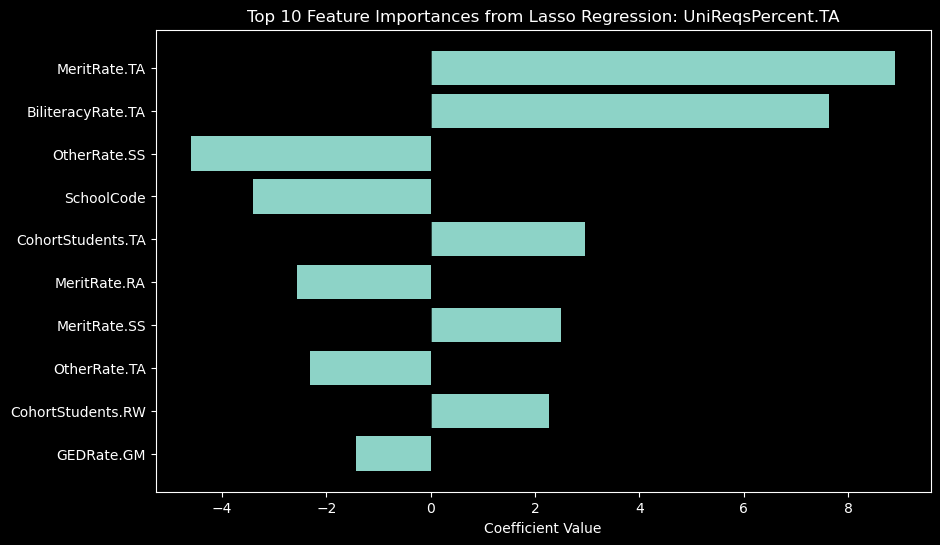

R^2 Score: 0.007720127178799219
Mean Squared Error: 1020.054158096372
Root Mean Squared Error: 31.93828671197583


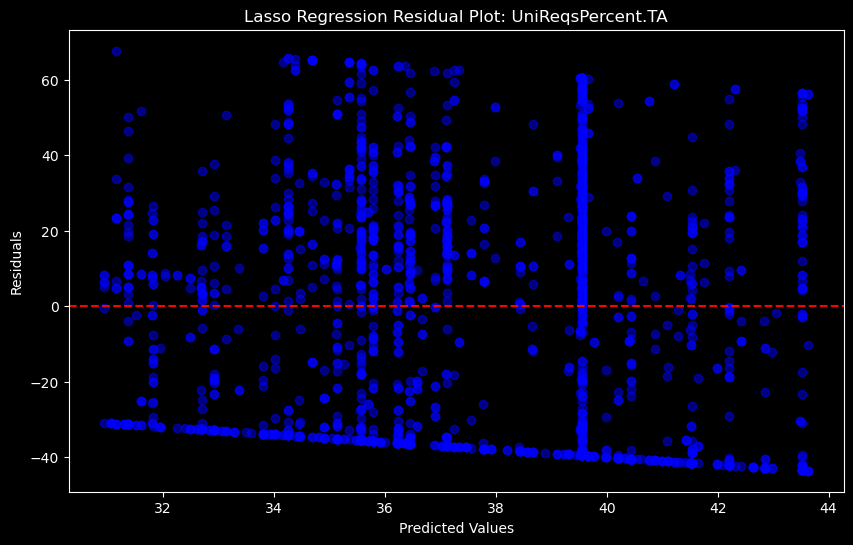

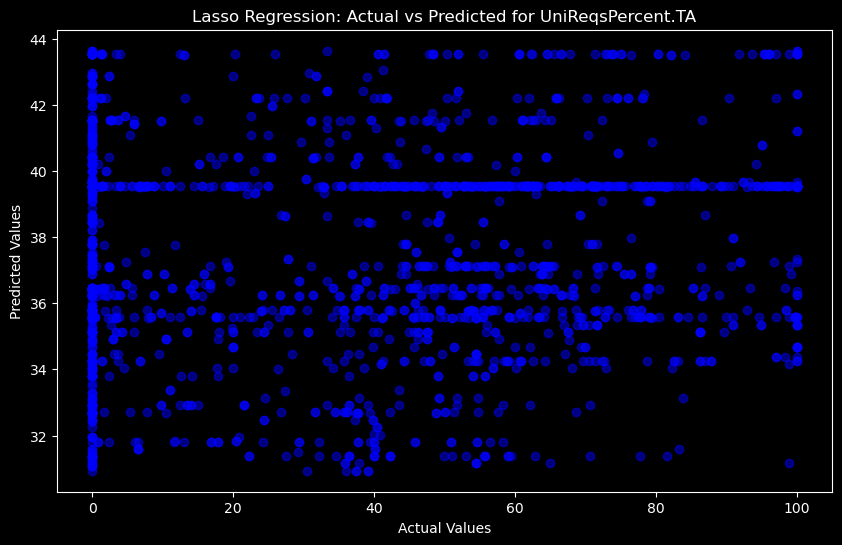

In [4]:
target_column = "UniReqsPercent.TA"


X_numeric, y, sorted_pairs = lasso_utils.fit_lasso_model(
    df_2020_21, target_column, columns_to_drop
)


lasso_utils.plot_lasso_coefficients(target_column, sorted_pairs)
lasso_model = lasso_utils.LassoCV(cv=5, random_state=42, max_iter=10000)
lasso_results = lasso_utils.train_and_evaluate_lasso_model(X_numeric, y, lasso_model)

print(f"R^2 Score: {lasso_results['r2']}")
print(f"Mean Squared Error: {lasso_results['mse']}")
print(f"Root Mean Squared Error: {lasso_results['rmse']}")

lasso_utils.plot_lasso_residuals(
    lasso_results["y_test"], lasso_results["y_pred"], target_column
)
lasso_utils.plot_actual_predicted_lasso(
    lasso_results["y_test"], lasso_results["y_pred"], target_column
)

# XGBoost

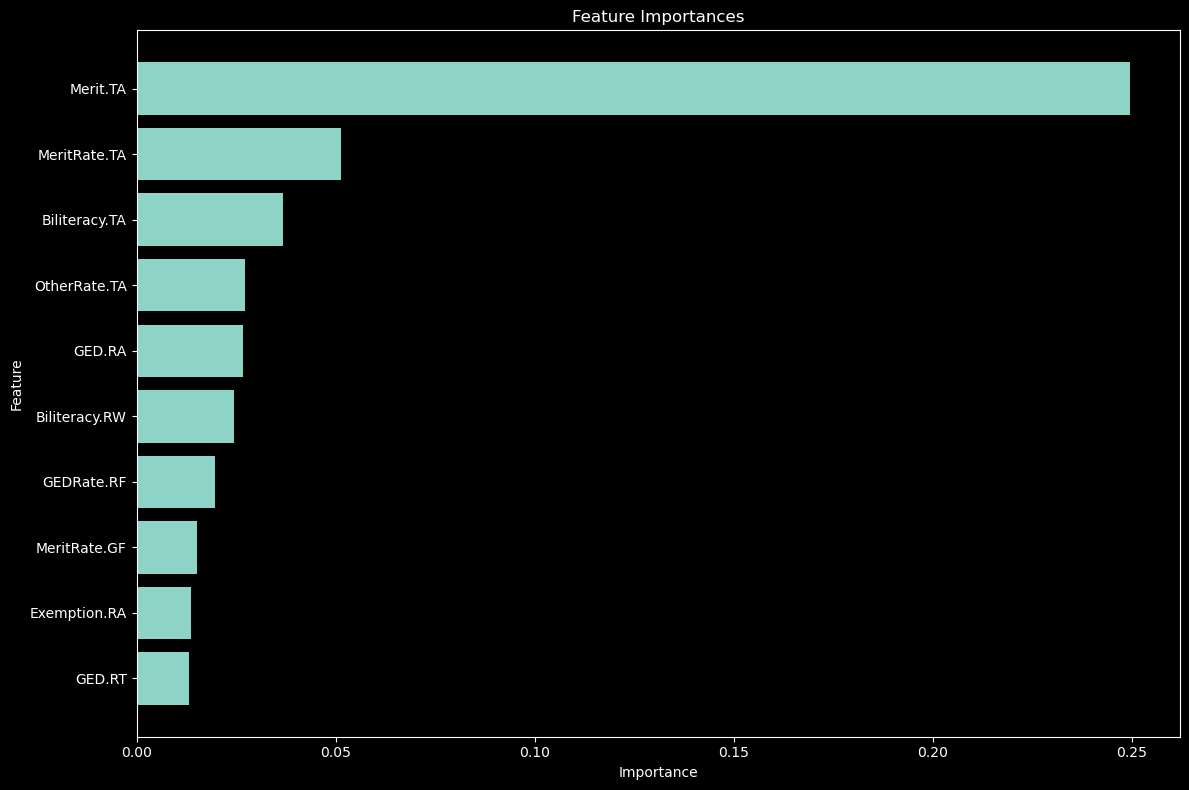

{'MSE': 63.77830390773183, 'RMSE': 7.986131974099341, 'MAE': 5.2951377536521465, 'R^2': 0.937958267423349}


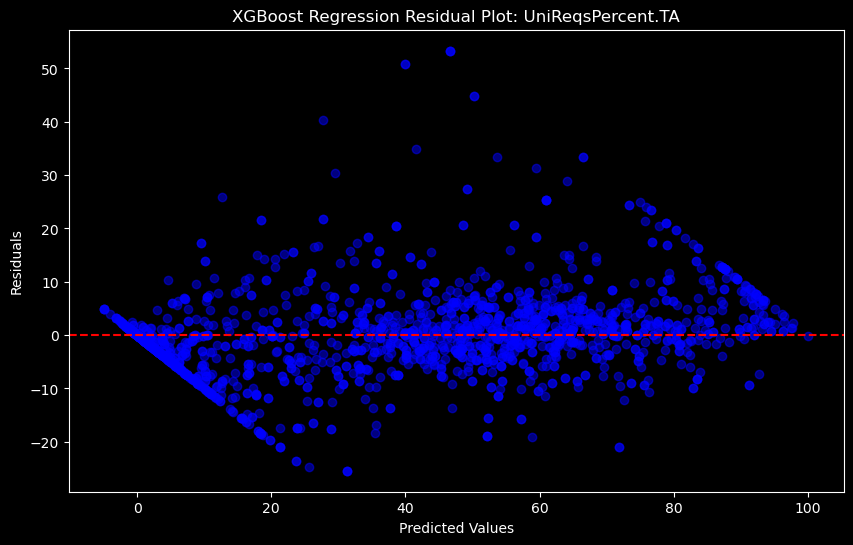

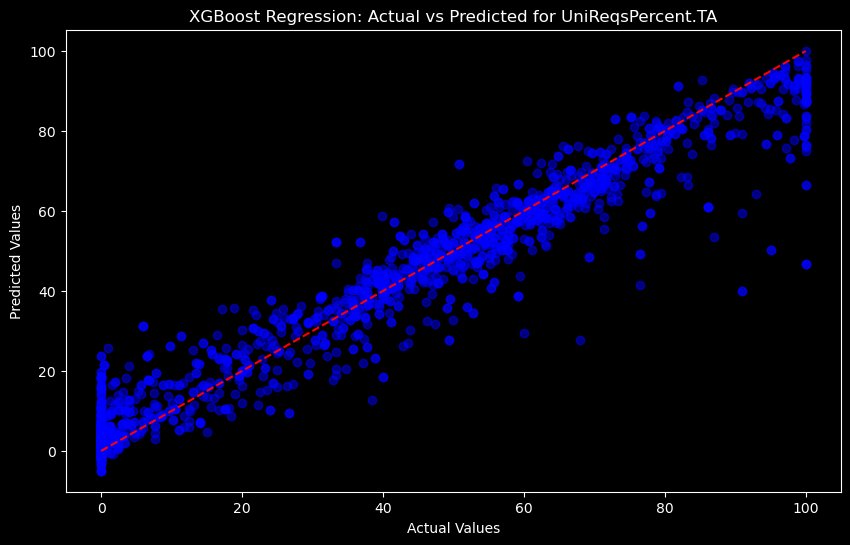

In [5]:
import modeling.utils.xgboost as xgb_utils

target_column = "UniReqsPercent.TA"
xgb_results = xgb_utils.train_xgboost_model(df_2020_21, target_column, columns_to_drop)
print(xgb_results["metrics"])
xgb_utils.plot_xgb_residuals(
    xgb_results["y_test"], xgb_results["y_pred"], target_column
)
xgb_utils.plot_xgb_predicted_actual(
    xgb_results["y_test"], xgb_results["y_pred"], target_column
)

## Graduation Rate

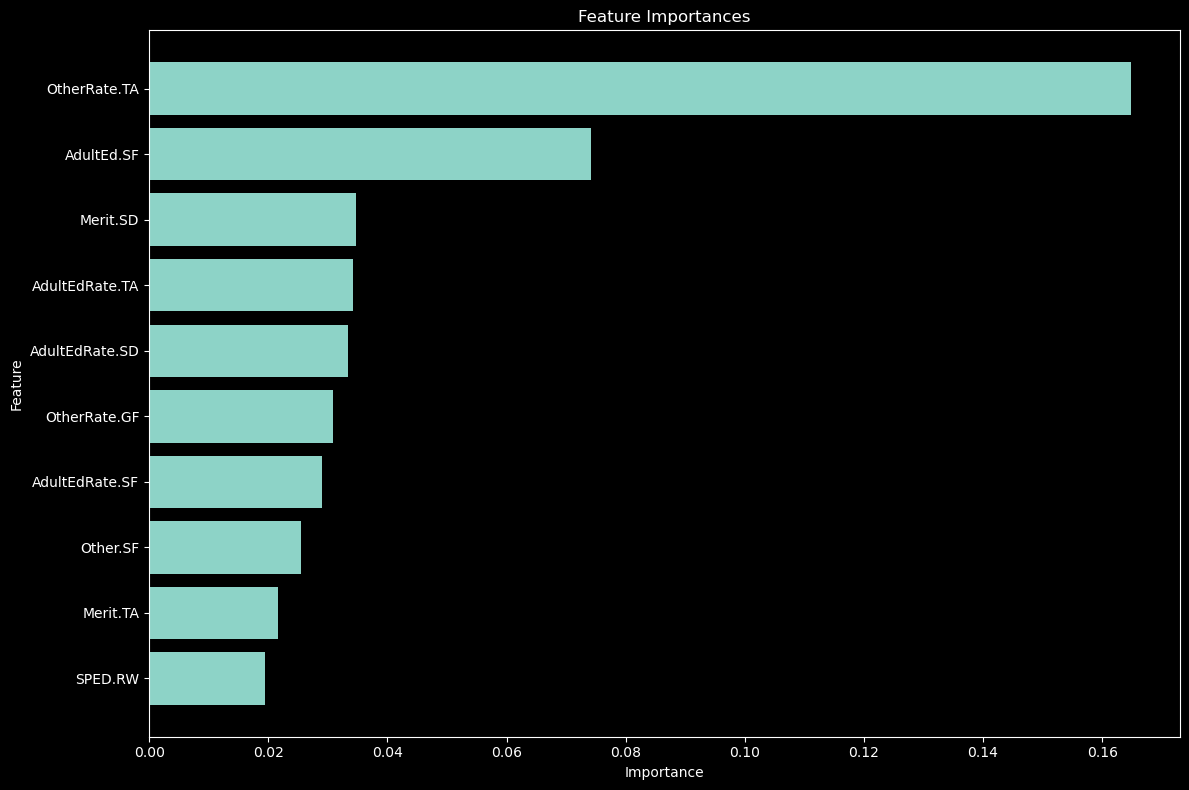

{'MSE': 18.25683834775736, 'RMSE': 4.27280216576398, 'MAE': 2.657212246130956, 'R^2': 0.9681568662970653}


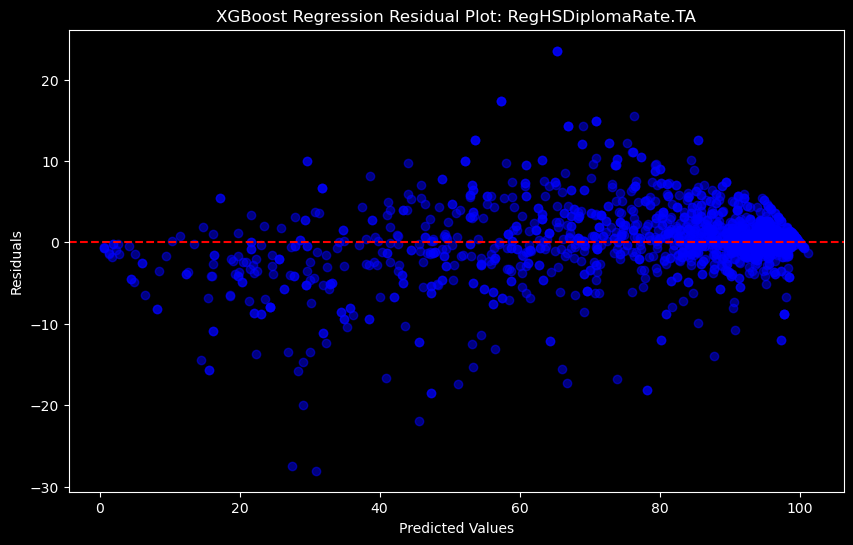

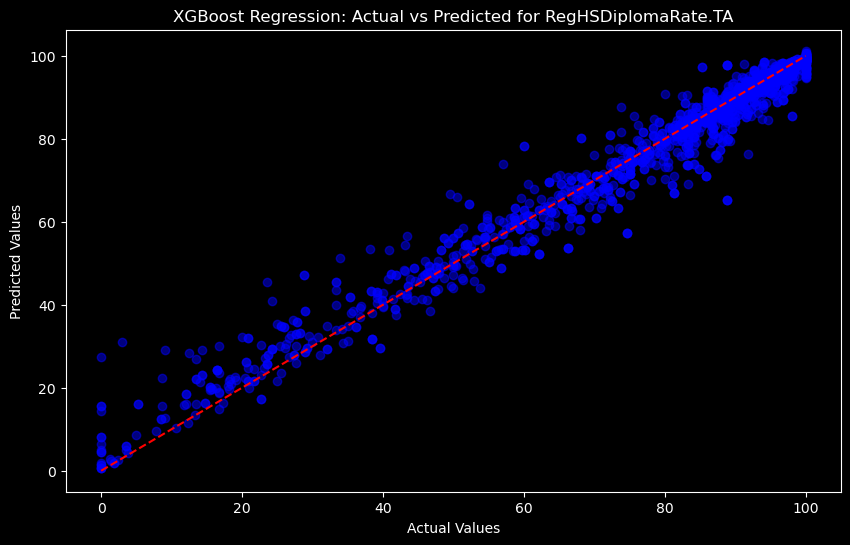

In [6]:
target_column = "RegHSDiplomaRate.TA"
xgb_results = xgb_utils.train_xgboost_model(df_2020_21, target_column, columns_to_drop)
print(xgb_results["metrics"])
xgb_utils.plot_xgb_residuals(
    xgb_results["y_test"], xgb_results["y_pred"], target_column
)
xgb_utils.plot_xgb_predicted_actual(
    xgb_results["y_test"], xgb_results["y_pred"], target_column
)

# Random Forest

Predict Graduation Rate

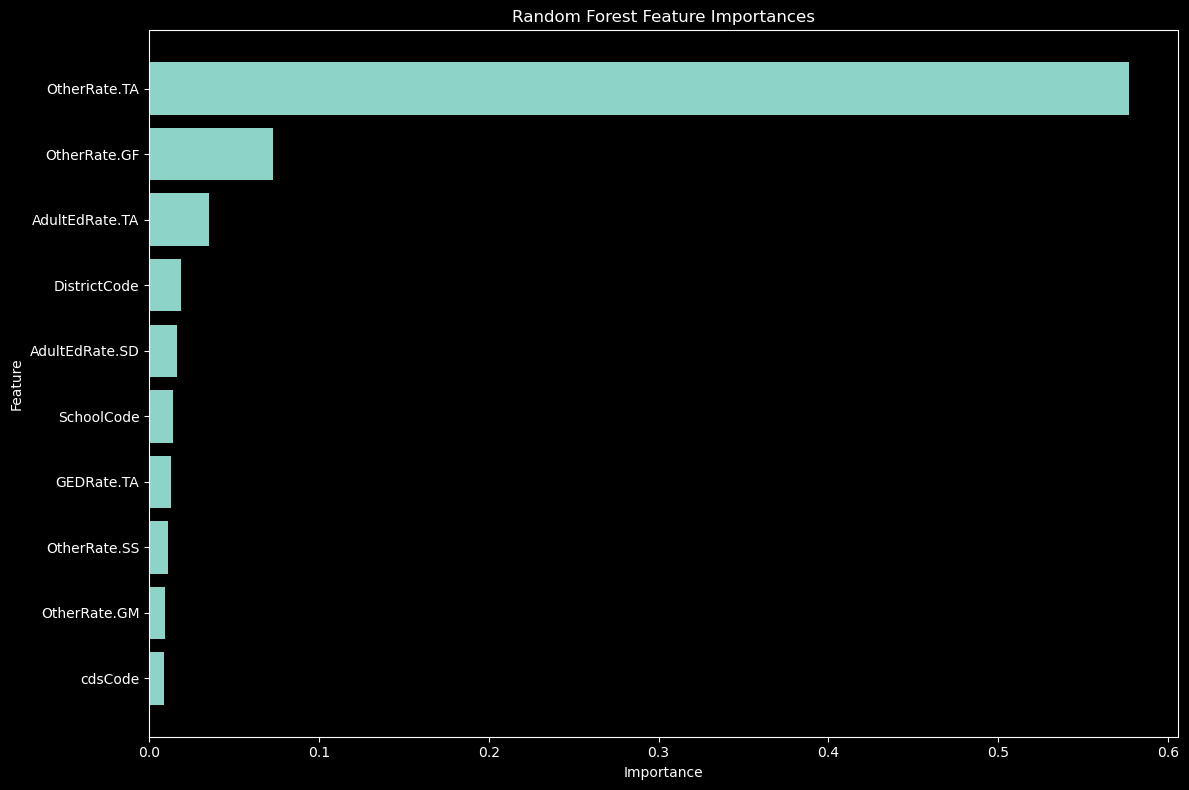

{'MSE': 2.9683448173971723, 'RMSE': 1.7228885098569704, 'R²': 0.9942196637791401}


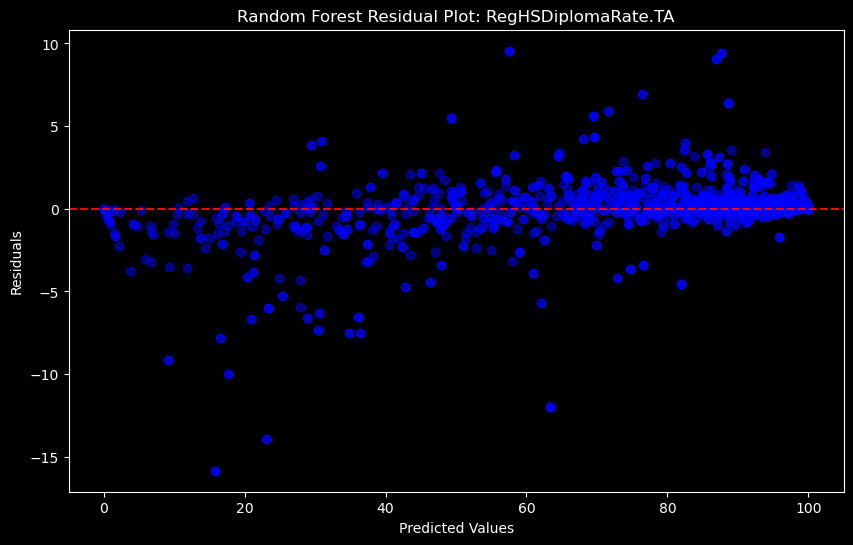

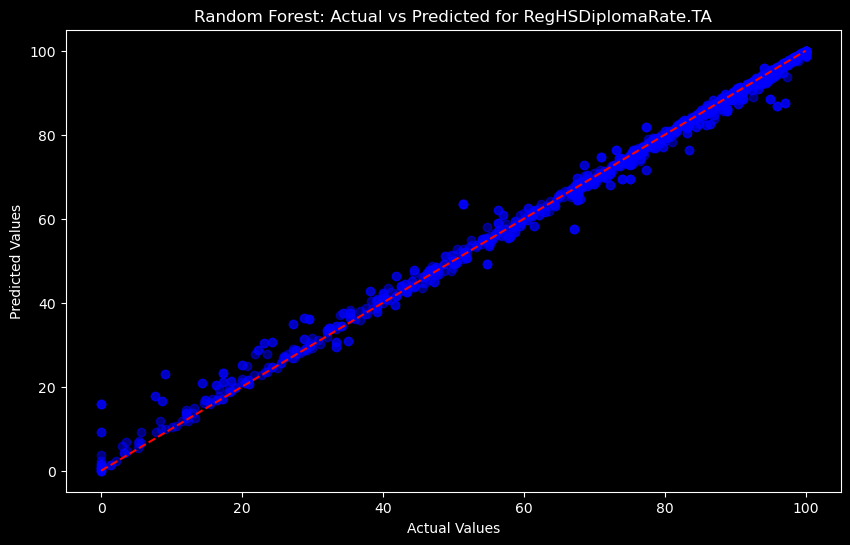

In [7]:
import modeling.utils.randomforest as rf_utils

df_2020_21_clean = df_2020_21.copy()
df_2020_21_clean = df_2020_21_clean.select_dtypes(include=[np.number])  # Keep only numeric columns
df_2020_21_clean = df_2020_21_clean.fillna(df_2020_21_clean.mean())  # Impute with mean

# Filter columns_to_drop to include only columns that exist in merged_clean
columns_to_drop_filtered = [col for col in columns_to_drop if col in df_2020_21_clean.columns]

rf_grad = rf_utils.train_random_forest_model(df_2020_21_clean, "RegHSDiplomaRate.TA", columns_to_drop_filtered)
print(rf_grad["metrics"])
rf_utils.plot_rf_residuals(rf_grad["y_test"], rf_grad["y_pred"], "RegHSDiplomaRate.TA")
rf_utils.plot_rf_actual_predicted(rf_grad["y_test"], rf_grad["y_pred"], "RegHSDiplomaRate.TA")

Predict CSU/UC Readiness


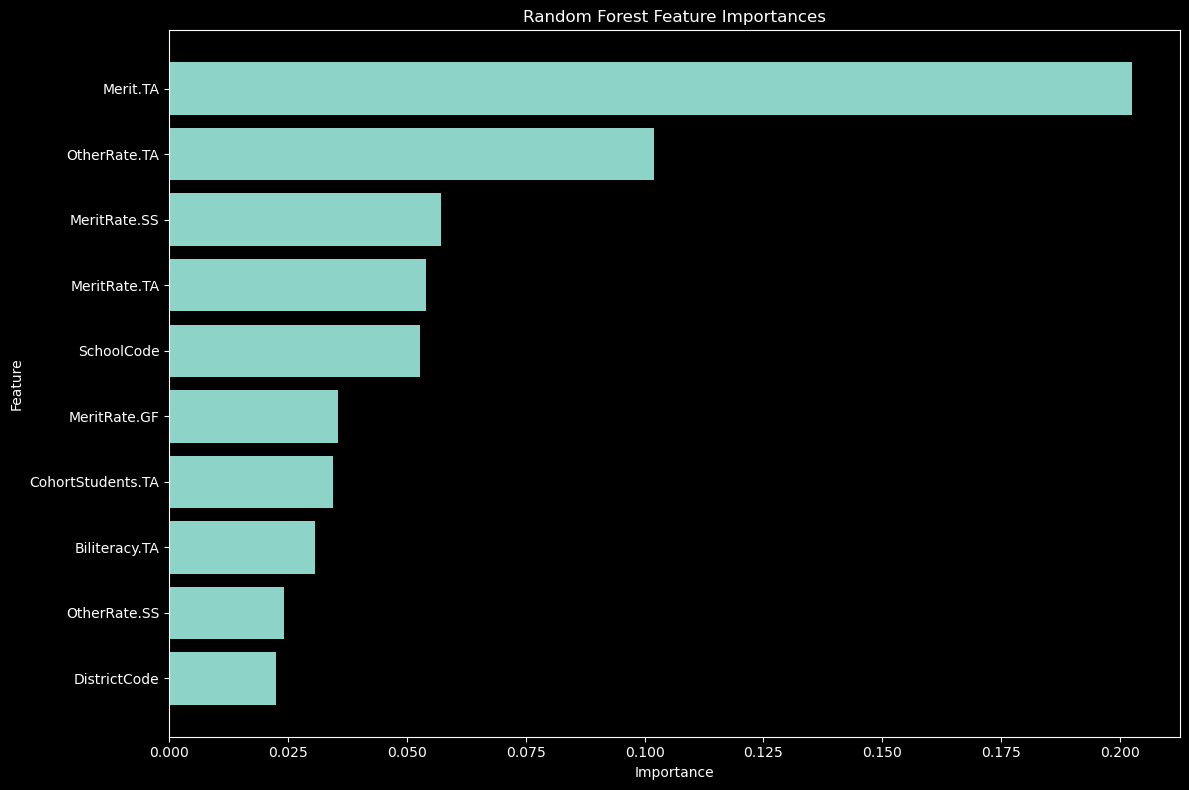

{'MSE': 9.501902273022107, 'RMSE': 3.0825155754711293, 'R²': 0.9894854800846902}


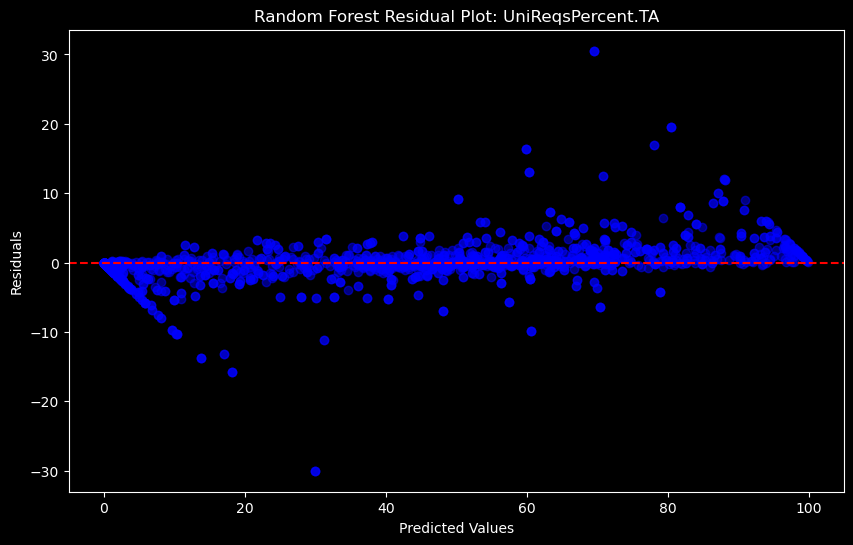

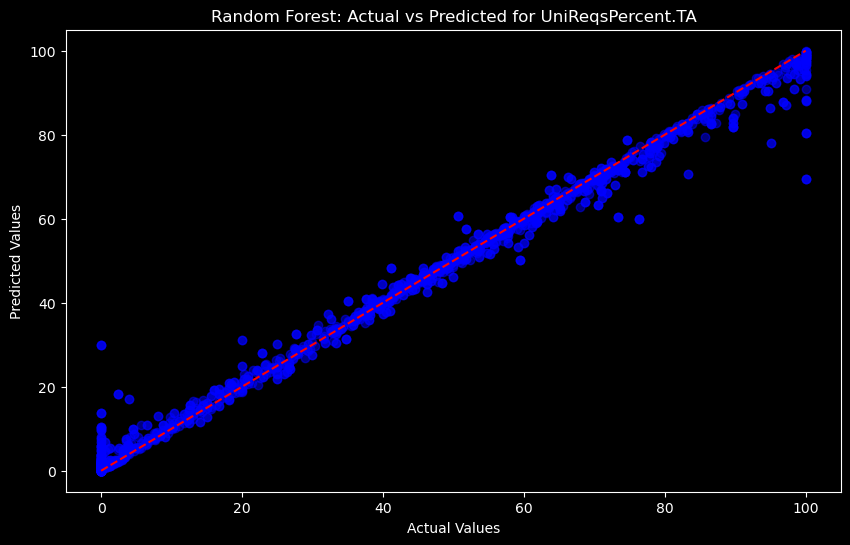

In [8]:
rf_uni = rf_utils.train_random_forest_model(df_2020_21_clean, "UniReqsPercent.TA", columns_to_drop_filtered)
print(rf_uni["metrics"])
rf_utils.plot_rf_residuals(rf_uni["y_test"], rf_uni["y_pred"], "UniReqsPercent.TA")
rf_utils.plot_rf_actual_predicted(rf_uni["y_test"], rf_uni["y_pred"], "UniReqsPercent.TA")

Predict Dropout Rate

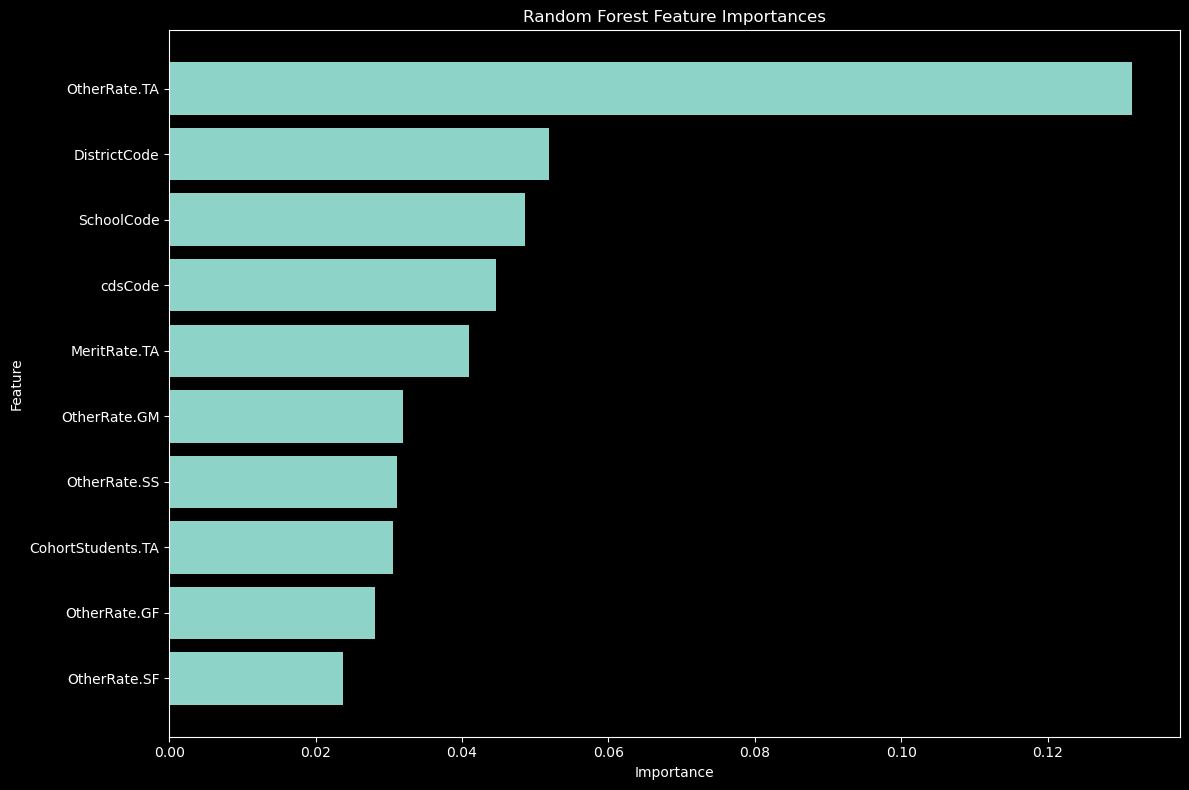

{'MSE': 2.690719233484791, 'RMSE': 1.6403411942290516, 'R²': 0.9864196622590786}


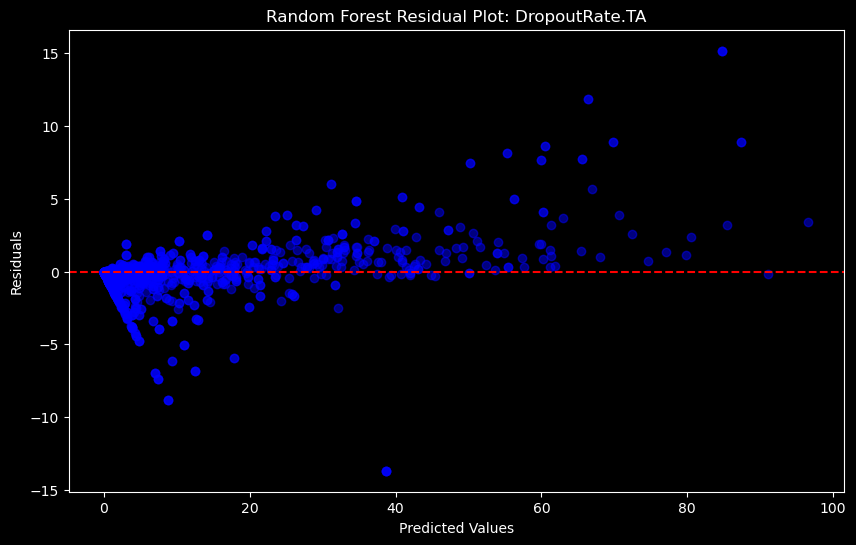

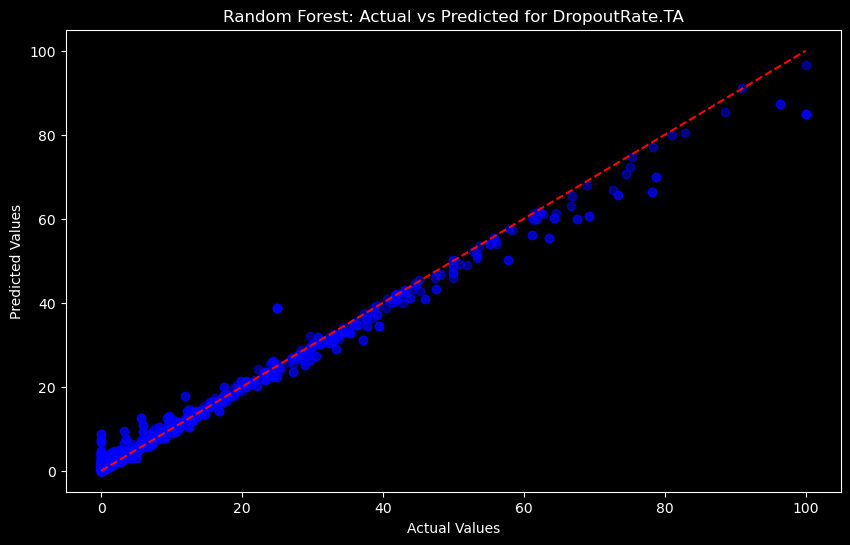

In [9]:
rf_dropout = rf_utils.train_random_forest_model(df_2020_21_clean, "DropoutRate.TA", columns_to_drop_filtered)
print(rf_dropout["metrics"])
rf_utils.plot_rf_residuals(rf_dropout["y_test"], rf_dropout["y_pred"], "DropoutRate.TA")
rf_utils.plot_rf_actual_predicted(rf_dropout["y_test"], rf_dropout["y_pred"], "DropoutRate.TA")